## Unsupervised Siamese Neuronal Network: Anchor - Positive - Negative

Import libraries

In [6]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import joblib
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn import metrics

import cv2

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Activation, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from albumentations import *
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import OpticalDistortion
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt

Data Loading

In [7]:
# Load the labeled faces in the wild dataset using scikit-learn's fetch_lfw_people function.
faces = fetch_lfw_people(min_faces_per_person=4, resize= 1, color=True, slice_=(slice(15, 235), slice(15, 235)))

# Get the number of unique classes in the dataset by counting the number of unique target names.
class_count = len(faces.target_names)
print(class_count)

610


Example of the images

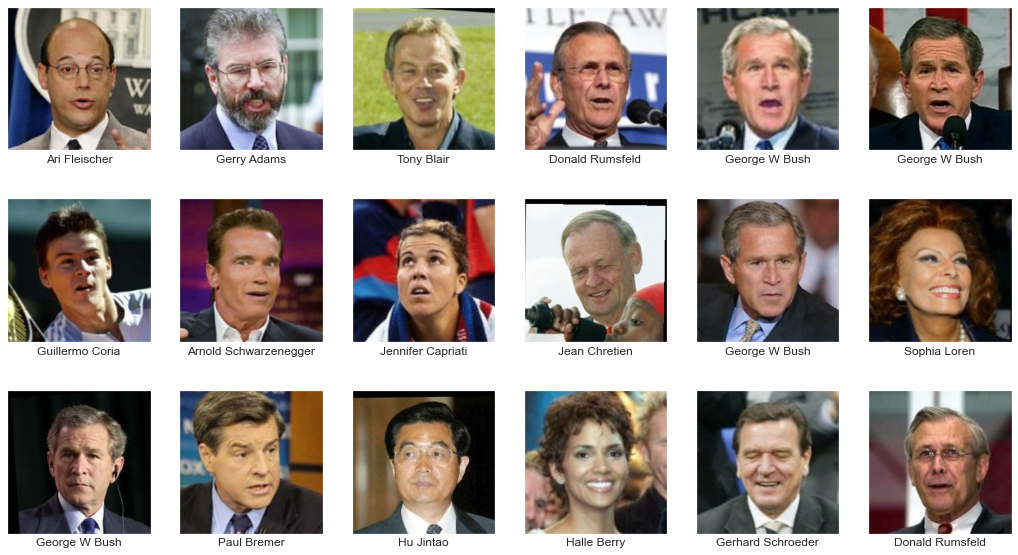

In [8]:
# Create a 3x6 grid of plots to display a sample of the images in the dataset.
sns.set()
fig, ax = plt.subplots(3, 6, figsize=(18, 10))

# For each plot in the grid, show an image from the dataset, scaled to values between 0 and 1 using division by 255.
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255)
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Image pre-processing

In [9]:
# Convert the images and labels to NumPy arrays.
face_images = np.array(faces.images)
face_labels = np.array(faces.target)

# Get the shape of the images in the dataset.
target_shape = face_images[0].shape

# Convert face_images into array
face_images = np.array(face_images, dtype="float32") 

Data Augmentation

In [ ]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    featurewise_std_normalization=True, # Featurise Standar Normalization
    brightness_range= [0.5, 1.1], # Change brightness
    rotation_range=0.3, # Degrees (0 to 180) to randomly rotate images
    horizontal_flip=True, # Randomly flip images horizontally
    zoom_range=0.4, # Range for random zoom (0 to 1)
    fill_mode='nearest', # Strategy for filling in newly created pixels (e.g. when rotating)
    shear_range=5.0, # Shear range
    rescale=1. / 255, # Convert the pixel values of the images to floating point numbers between 0 and 1.
)

# Create an ImageDataGenerator object
datagen_rescale = ImageDataGenerator(
    rescale=1. / 255, # Convert the pixel values of the images to floating point numbers between 0 and 1.
    brightness_range= [0.5, 1.3], # Change brightness
)

# Create an ImageDataGenerator object
datagen_rescale_test = ImageDataGenerator(
    rescale=1. / 255, # Convert the pixel values of the images to floating point numbers between 0 and 1.
)


In [6]:
def generate_image_pairs(images, labels):
    
    """
    This function generates image pairs for training a Siamese Neural Network model.
    
    Parameters:
    images: array-like, shape (n_samples, height, width, channels)
            The images to use for generating the pairs.
    labels: array-like, shape (n_samples,)
            The labels corresponding to each image.
    
    Returns:
    pair_images: array-like, shape (n_pairs, 3, height, width, channels)
                 The generated pairs of images.
    pair_images_test: array-like, shape (n_pairs_test, 3, height, width, channels)
                      The generated pairs of images for testing purposes.
    """
    
    # Get unique labels in the dataset
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    
    # Create a dictionary containing a list of indices for each unique label
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    remove_index = []
    get_less_index = []
    
    # Get indices to remove if there are more than 30 images for a label
    # Get indices for labels with less than 5 images to include in testing data
    for value in label_wise_indices.values():
        if len(value) >= 45:
            remove_index.append(value[30:])
        if len(value) < 5:
            get_less_index.append(value[0:5])
  
    # Flatten the list of indices to remove and the list of indices to get for testing
    merged = list(itertools.chain(*remove_index))
    get_less = list(itertools.chain(*get_less_index))

    pair_images = []
    pair_images_test = []

    for index, image in enumerate(images):
        
        # Skip image if it needs to be removed
        if index not in merged + get_less:
            
            # Triplet anchor - positive same person but different image - negative
            pos_indices = label_wise_indices.get(labels[index]) 
            pos_image = images[np.random.choice(pos_indices)] 
            neg_indices = np.where(labels != labels[index])
            neg_image = images[np.random.choice(neg_indices[0])] 
            
            # Apply transformations  
            aug_iter_2 = datagen.flow(pos_image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale.flow(neg_image.reshape((1,220,220,3)),batch_size=1)
            
            # Generate batch of images
            for i in range(2):
           
                # Generate images
                image_anchor = next(aug_rescale_p)[0]
                neg_image_n = next(aug_rescale_n)[0]
                image2 = next(aug_iter_2)[0]
                
                # Create pairs
                pair_images.append((image_anchor, image2, neg_image_n))
            
            # Triplet anchor - positive same image anchor - negative
            
            # Apply transformations 
            aug_iter_2 = datagen.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale.flow(neg_image.reshape((1,220,220,3)),batch_size=1)
          
            # Generate batch of images
            for i in range(2):
         
                # Generate images
                image_anchor = next(aug_rescale_p)[0]
                neg_image_n = next(aug_rescale_n)[0]
                image2 = next(aug_iter_2)[0]
                
                # Create pairs
                pair_images.append((image_anchor, image2, neg_image_n))
            
       # Add images with less than 5 examples to testing data
        if index in get_less:
            
            # Randomly select an image with same label as current image
            pos_indices = label_wise_indices.get(labels[index]) 
            pos_image = images[np.random.choice(pos_indices)] 

            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index])
            neg_image = images[np.random.choice(neg_indices[0])] 
            
            # Apply transformations
            aug_iter_2 = datagen.flow(pos_image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale.flow(neg_image.reshape((1,220,220,3)),batch_size=1)
           
            # Generate batch of images
            for i in range(1):
    
                # Generate images
                image_1 = next(aug_iter_2)[0]
                image = next(aug_rescale_p)[0]
                neg_image = next(aug_rescale_n)[0]
       
                # Create Pairs 
                pair_images_test.append((image, image_1, neg_image))
                   
    # Return numpy arrays for image pairs and training and testing data       
    return np.array(pair_images), np.array(pair_images_test)    


In [ ]:
# Generate image pairs from the input images and labels
images_dataset, image_dataset_test = generate_image_pairs(face_images, face_labels)

# Shuffle the generated image pairs and corresponding labels
images_dataset = shuffle(images_dataset)

Visualization of the positive and negative pairs

In [ ]:
def visualize(image_pairs,  n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    # Define a helper function to show an image in a subplot
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # Create a figure and subplots for displaying the image pairs
    fig = plt.figure(figsize=(30, 30)) 
    plt.title(title)
    axs = fig.subplots(n, 3)
    
    # Iterate over the first n image pairs
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])
        show(axs[i, 2], image_pairs[i][2])

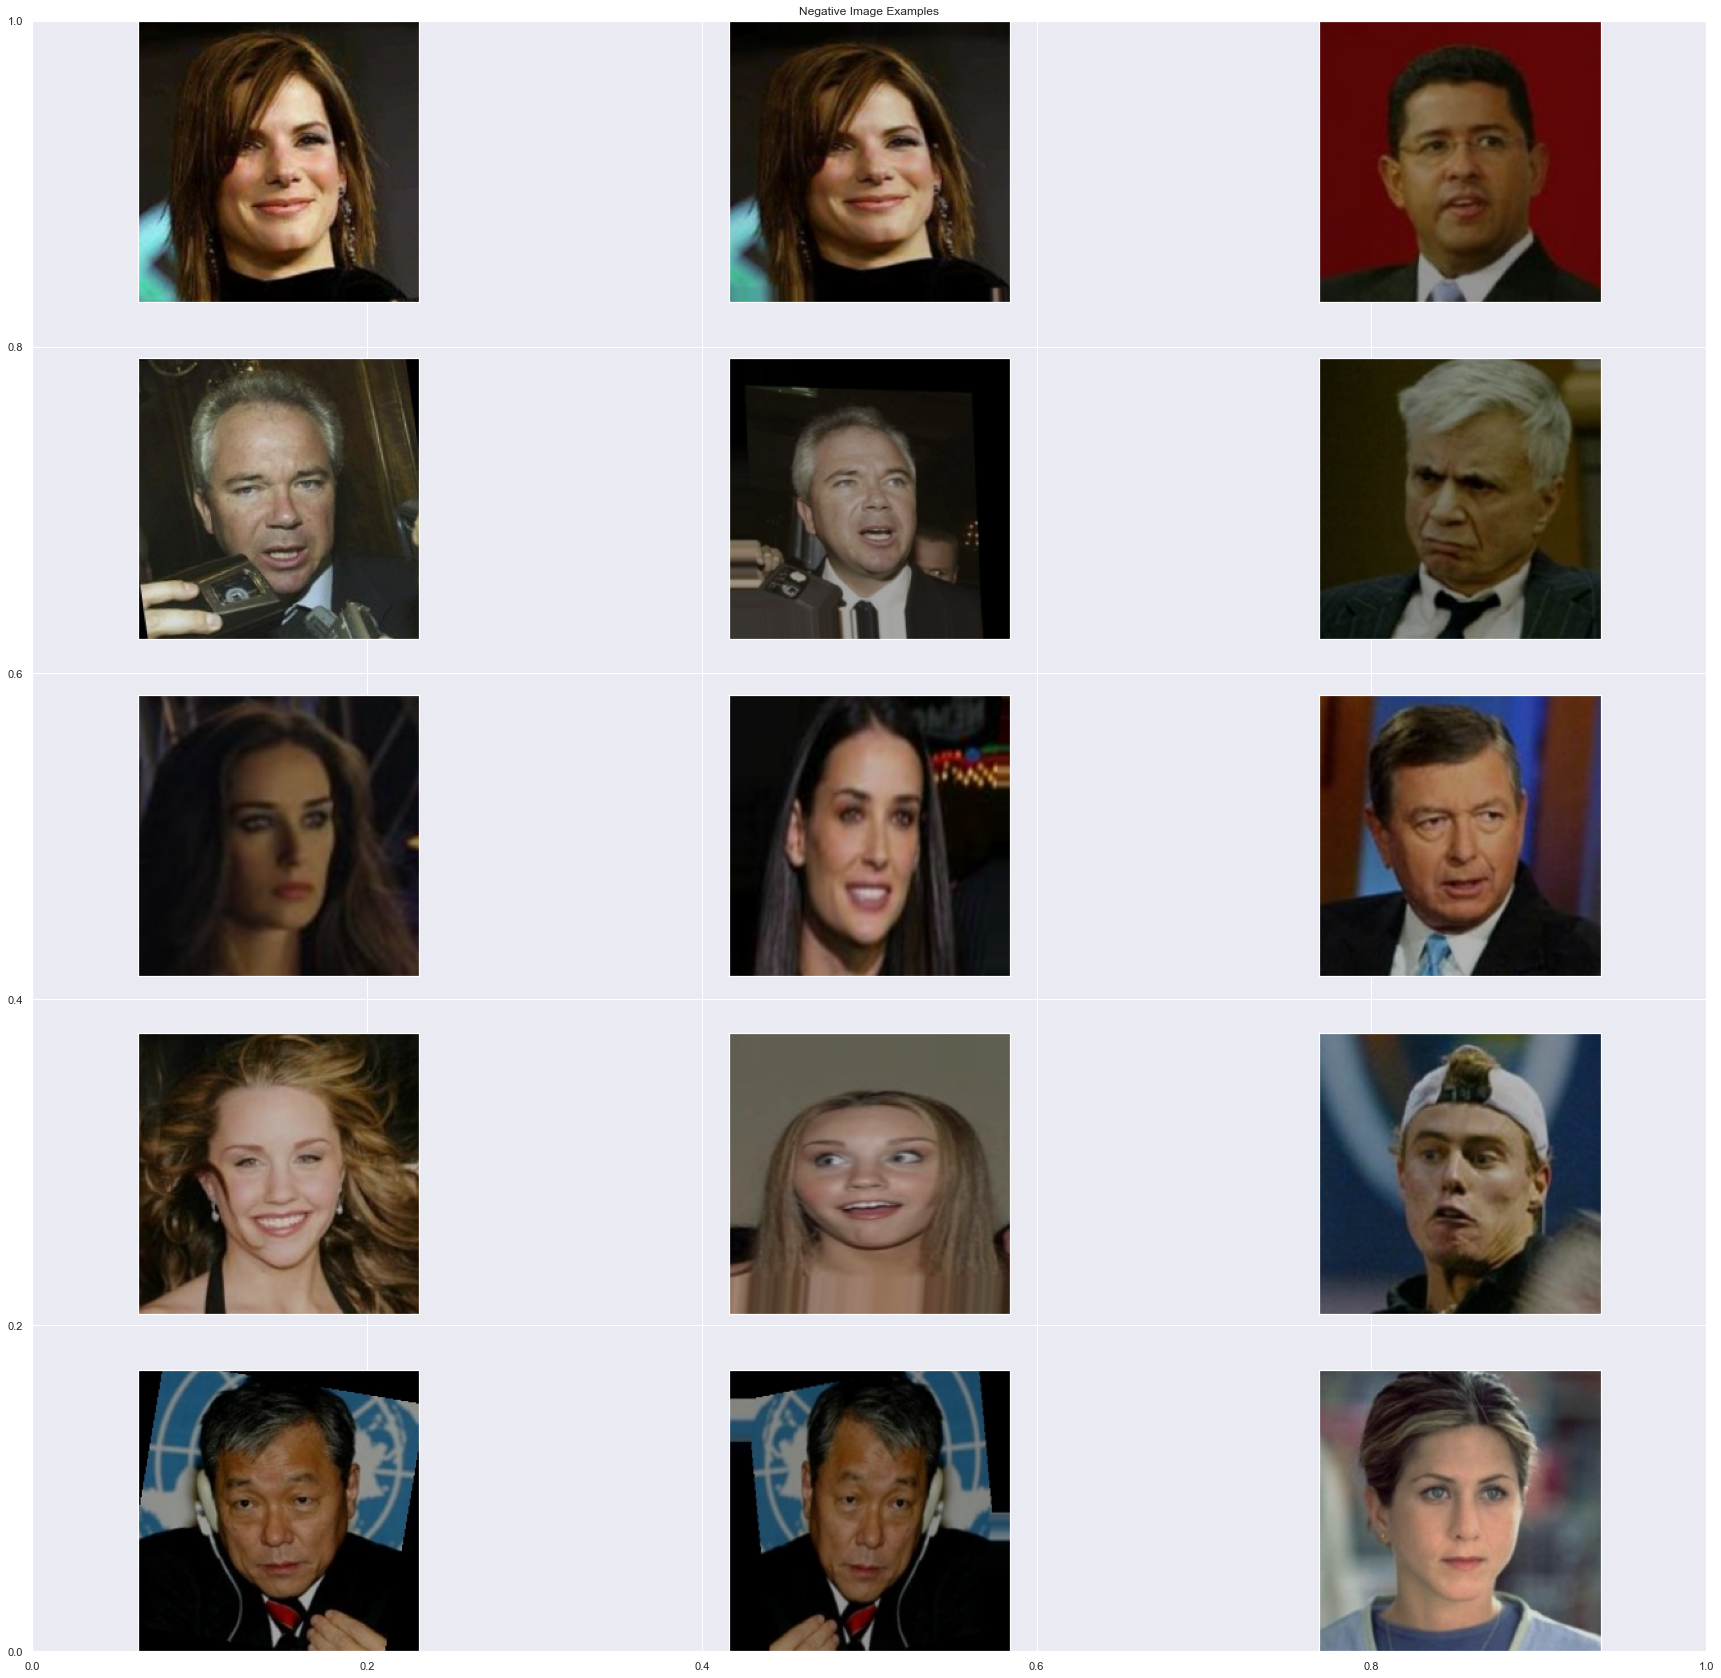

In [56]:
n = 5
# Get sample
visualize(image_dataset[0:n],
          title = "Negative Image Examples")

In [191]:
class DistanceLayer(layers.Layer):
    """
        This layer is responsible for computing the distance between the anchor
        embedding and the positive embedding, and the anchor embedding and the
        negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


In [192]:
class SiameseModel(Model):
    """
    SiameseModel: class that implements a siamese neural network for image similarity learning.

    The class inherits from tf.keras.Model, and defines the following methods:

    init: Initializes the class instance.
    _build_embedding: Builds the embedding subnetwork.
    _build_siamese_network: Builds the siamese subnetwork.
    call: Overrides the call method of tf.keras.Model.
    train_step: Overrides the training step method of tf.keras.Model.
    test_step: Overrides the testing step method of tf.keras.Model.
    _compute_loss: Computes the loss of the siamese network.
    metrics: Returns a list of metrics to evaluate the model.
    The class also defines the following instance variables:

    target_shape: A tuple representing the input shape of the model.
    fineTune: A boolean indicating whether the model should be fine-tuned or not.
    margin: A float representing the margin parameter for the contrastive loss function.
    embedding: A tf.keras.Model instance representing the embedding subnetwork.
    siamese_network: A tf.keras.Model instance representing the siamese subnetwork.
    loss_tracker: A tf.keras.metrics.Mean instance representing the loss metric.
    """
        
    def __init__(self, target_shape, fineTune=True, margin=1):
        super().__init__()
        self.target_shape = target_shape
        self.fineTune = fineTune
        self.margin = margin
        self.embedding = self._build_embedding()
        self.siamese_network = self._build_siamese_network()
        self.loss_tracker = metrics.Mean(name="loss")

    # Create function to build embedding model  
    def _build_embedding(self):
        
        # Define input layer
        inputs = tf.keras.layers.Input((220, 220, 3))

        # Load pre-trained VGG19 model
        base_model = tf.keras.applications.vgg19.VGG19(
            input_shape=(220, 220, 3), include_top=False, weights="imagenet"
        )

        if self.fineTune == True:
            base_model.trainable = True
        # Freeze all the layers if fineTune is False
        else:
            base_model.trainable = False

        # Connect input to base model and add dense layers
        x = base_model(inputs)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(128)(x)
        return tf.keras.Model(inputs, outputs)

    # Create function to build siamese network
    def _build_siamese_network(self):
        
        # Define input layers for anchor, positive, and negative images
        anchor_input = layers.Input(name="anchor", shape=(220, 220, 3))
        positive_input = layers.Input(name="positive", shape=(220, 220, 3))
        negative_input = layers.Input(name="negative", shape=(220, 220, 3))

        # Compute distances between anchor, positive, and negative embeddings using custom DistanceLayer
        distances = DistanceLayer()(
            self.embedding(anchor_input),
            self.embedding(positive_input),
            self.embedding(negative_input),
        )

        # Define and return siamese network
        return Model(
            inputs=[anchor_input, positive_input, negative_input], outputs=distances
        )

    # Define call function to call siamese network
    def call(self, inputs):
        return self.siamese_network(inputs)
    
    # Define train_step function to train model on a single batch of data
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(
            loss, self.siamese_network.trainable_weights
        )

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    # Define test_step function to evaluate model on a single batch of data
    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    # Define function to compute contrastive loss on a single batch of data
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


The margin hyperparameter in the contrastive loss function determines the minimum distance between the positive and negative embeddings that is required for the loss to be non-zero. The optimal margin value can vary depending on the specific problem and dataset being used, and typically needs to be tuned through experimentation.

In [ ]:
# Create a SiameseModel object with input shape of (220, 220, 3)
siamese_model_triplet = SiameseModel(target_shape=(220, 220, 3))

# Compile the model using RMSprop optimizer and 'loss' metric
siamese_model_triplet.compile(optimizer="RMSprop", metrics=['loss'])

# Train the model using the images_dataset and batch size of 8 for 10 epochs
triplet = siamese_model_triplet.fit([images_dataset[:, 0, :], images_dataset[:, 1, :], images_dataset[:, 2, :]], 
                             batch_size=8, epochs=10)


In [15]:
def plot_graphics(model):
    
    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # Plot the training and validation loss for each epoch in the first subplot
    ax.plot(np.arange(0,len(model.history["loss"]) ), model.history["loss"], label="loss")
    ax.set_title('loss', fontsize=16)
    plt.legend()

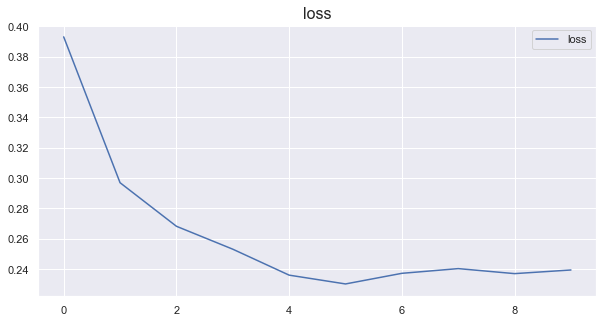

In [19]:
plot_graphics(triplet)

In [ ]:
siamese_model_triplet.siamese_network.save(r'../FINALPOSDATAAUG-model_triplet_test_final_version.pkl')

In [ ]:
loaded_model_triplet = tf.keras.models.load_model(r'FINALPOSDATAAUG-model_triplet_test_final_version.pkl')

Train Step

In [17]:
# Calculate Scores of the train data 
distances_trained = loaded_model_triplet.predict([images_dataset[:, 0, :], images_dataset[:, 1, :], images_dataset[:, 2, :]])

594/594 [==============================] - 1823s 3s/step


In [23]:
# Create data frame with the scores and labels
df_distances_t= pd.DataFrame(distances_trained).T
df_distances_t.columns = ['positive', 'negative']

y = list(range(0,df_distances_t.shape[0])) + list(range(0, df_distances_t.shape[0]))
df_distances_t= pd.melt(df_distances_t, value_vars=['positive', 'negative'], var_name='category',
value_name='distance')

df_distances_t['y'] = y 

df_distances_t.loc[df_distances_t['category']=='positive', 'binary'] = 1
df_distances_t.loc[df_distances_t['category']=='negative', 'binary'] = 0


In [25]:
# Calculate tpr, fpr, thresholds
fpr, tpr, thresholds = roc_curve(df_distances_t.binary, 
                                 df_distances_t.distance)

In [26]:
# Create data frame with the roc information
df_roc = pd.DataFrame({'FPR': fpr,
                           'TPR': tpr,
                           'Threshold': thresholds})

df_roc['FPR'] = (1- df_roc['FPR'])*100
df_roc['TPR'] = (1- df_roc['TPR'])*100

In [28]:
# Calculate AUC
1 - metrics.auc(fpr, tpr)

0.8609555107316058

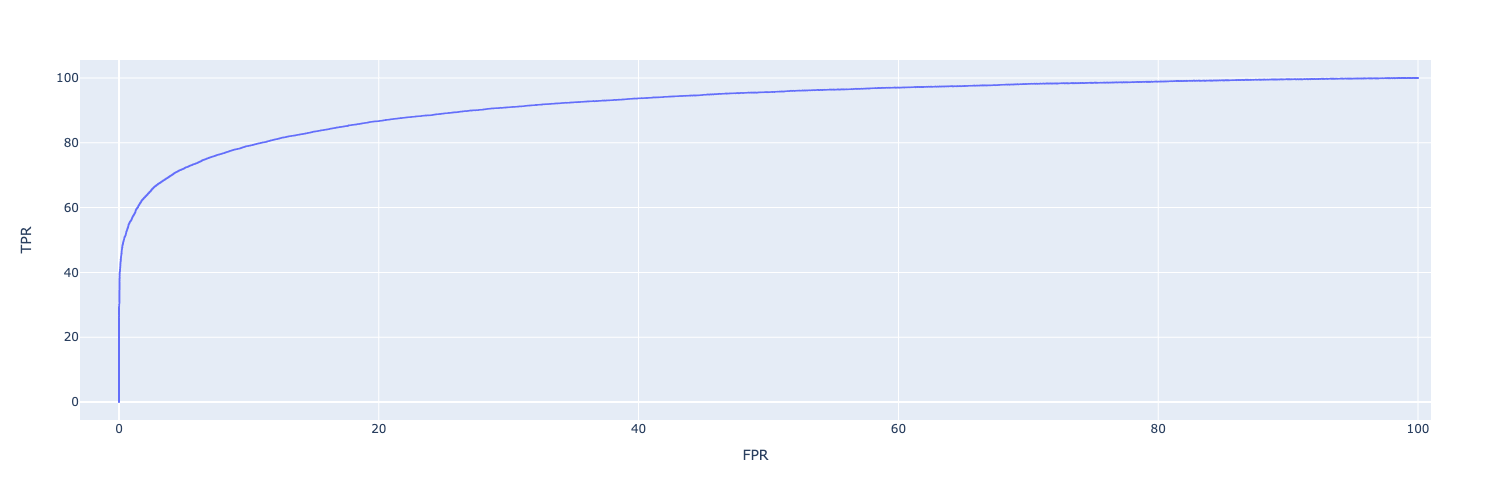

In [45]:
# Plot ROC curve
fig = px.line(df_roc, x='FPR', y='TPR', custom_data={'Threshold', 'FPR', 'TPR'},
                      height=500,  width=500) 

fig.update_layout(
                      xaxis_range=[-3, 101],
)

fig.update_traces(mode="lines", 
                   hovertemplate = "Threshold %{customdata[1]:.2f}  <br> TPR %{customdata[2]:.2f}% <br> FPR %{customdata[0]:.2f}%")

Test Data

In [57]:
# Calculate scores for test dataset
distances_trained_test = loaded_model_triplet.predict([image_dataset_test[:, 0, :], image_dataset_test[:, 1, :], image_dataset_test[:, 2, :]])

24/24 [==============================] - 73s 3s/step


In [58]:
# Creation of a data set with the scores
df_distances_t = pd.DataFrame(distances_trained_test).T
df_distances_t.columns = ['positive', 'negative']

In [26]:
# Distribution of the positive images
df_distances_t['positive'].describe()

count    748.000000
mean      12.543104
std        9.467512
min        0.000000
25%        5.489744
50%       11.063915
75%       17.341120
max       58.117390
Name: positive, dtype: float64

In [27]:
# Distribution of the negative images
df_distances_t['negative'].describe()

count    748.000000
mean      34.731827
std       13.744464
min        9.729361
25%       24.976680
50%       31.878252
75%       41.493288
max       98.630829
Name: negative, dtype: float64

In [94]:
# Add true labels
df_distances_test = pd.DataFrame(distances_trained_test).T
df_distances_test.columns = ['positive', 'negative']

y = list(range(0,df_distances_test.shape[0])) + list(range(0, df_distances_test.shape[0]))
df_distances_test= pd.melt(df_distances_test, value_vars=['positive', 'negative'], var_name='category',
value_name='distance')

df_distances_test['y'] = y 

df_distances_test.loc[df_distances_test['category']=='positive', 'true_binary'] = 1
df_distances_test.loc[df_distances_test['category']=='negative', 'true_binary'] = 0

distances_array = (df_distances_test[['distance', 'y', 'true_binary']]).to_numpy()

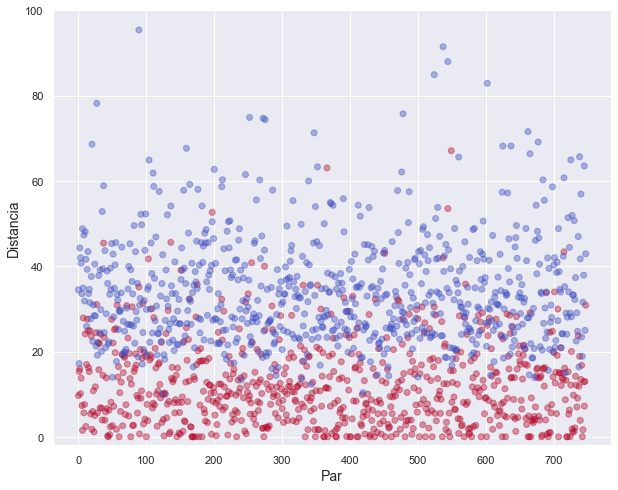

In [100]:
# Plot distances distribution
plt.figure(figsize=(10,8))
plt.scatter(distances_array[:,1], distances_array[:,0], c=distances_array[:,2], cmap='coolwarm', alpha= 0.4)
plt.xlabel('Par',fontsize=14)
plt.ylabel('Distancia',fontsize=14)
plt.ylim([-2, 100])
plt.show()

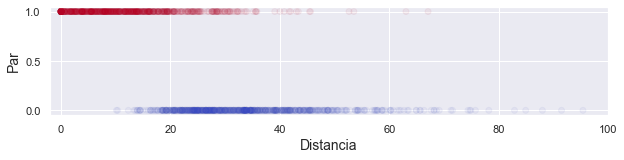

In [101]:
# Plot distances distribution
plt.figure(figsize=(10,2))
plt.scatter(distances_array[:,0], distances_array[:,2], c=distances_array[:,2], cmap='coolwarm', alpha=0.05)
plt.xlabel('Distancia',fontsize=14)
plt.ylabel('Par',fontsize=14)
plt.xlim([-2, 100])
plt.show()

In [27]:
# Creation data set for validation 
df_distances_test = pd.DataFrame(distances_trained_test).T
df_distances_test.columns = ['positive', 'negative']

y = list(range(0,df_distances_test.shape[0])) + list(range(0, df_distances_test.shape[0]))
df_distances_test= pd.melt(df_distances_test, value_vars=['positive', 'negative'], var_name='category',
value_name='distance')

df_distances_test['y'] = y 

df_distances_test.loc[df_distances_test['category']=='positive', 'true_binary'] = 1
df_distances_test.loc[df_distances_test['category']=='negative', 'true_binary'] = 0

In [102]:
# Calculate labels threshold 8
df_distances_test[['true_binary','distance']]
df_distances_test.loc[df_distances_test['distance'] > 8, 'distance_8'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 8, 'distance_8'] = 1

In [103]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_8']))

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77       748
         1.0       1.00      0.39      0.56       748

    accuracy                           0.70      1496
   macro avg       0.81      0.70      0.66      1496
weighted avg       0.81      0.70      0.66      1496



In [104]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_8'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

748 0 456 292


In [74]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.0


In [105]:
# Calculate labels threshold 18
df_distances_test.loc[df_distances_test['distance'] > 18, 'distance_18'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 18, 'distance_18'] = 1

In [106]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_18']))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87       748
         1.0       0.95      0.76      0.85       748

    accuracy                           0.86      1496
   macro avg       0.88      0.86      0.86      1496
weighted avg       0.88      0.86      0.86      1496



In [107]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_18'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

719 29 177 571


In [108]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.03877005347593583


In [109]:
# Calculate labels threshold 22
df_distances_test.loc[df_distances_test['distance'] > 22, 'distance_22'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 22, 'distance_22'] = 1

In [110]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_22']))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       748
         1.0       0.86      0.85      0.86       748

    accuracy                           0.86      1496
   macro avg       0.86      0.86      0.86      1496
weighted avg       0.86      0.86      0.86      1496



In [111]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_22'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

647 101 114 634


In [112]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.13502673796791445


In [113]:
# Calculate labels threshold 25
df_distances_test.loc[df_distances_test['distance'] > 25, 'distance_25'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 25, 'distance_25'] = 1

In [114]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_25']))

              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81       748
         1.0       0.78      0.89      0.83       748

    accuracy                           0.82      1496
   macro avg       0.83      0.82      0.82      1496
weighted avg       0.83      0.82      0.82      1496



In [115]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_25'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

564 184 82 666


In [116]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.24598930481283424


In [117]:
# Calculate labels threshold 15
df_distances_test.loc[df_distances_test['distance'] > 15, 'distance_15'] = 0
df_distances_test.loc[df_distances_test['distance'] <= 15, 'distance_15'] = 1

In [118]:
# Clasification report
print(classification_report(df_distances_test['true_binary'], df_distances_test['distance_15']))

              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85       748
         1.0       0.97      0.67      0.79       748

    accuracy                           0.83      1496
   macro avg       0.86      0.83      0.82      1496
weighted avg       0.86      0.83      0.82      1496



In [119]:
# Metrics
tn, fp, fn, tp = confusion_matrix(df_distances_test['true_binary'], df_distances_test['distance_15'], labels=[0, 1]).ravel()
print(tn, fp, fn, tp)  # 1 1 1 1

735 13 246 502


In [120]:
# FPR
fpr = fp / (fp + tn)
print(fpr)

0.017379679144385027


Example image

In [159]:
def generate_image_pairs_final_image(images, labels):
    
    """
    This function generates image pairs for training a Siamese Neural Network model.
    
    Parameters:
    images: array-like, shape (n_samples, height, width, channels)
            The images to use for generating the pairs.
    labels: array-like, shape (n_samples,)
            The labels corresponding to each image.
    
    Returns:
    pair_images: array-like, shape (n_pairs, 3, height, width, channels)
                 The generated pairs of images.
    pair_images_test: array-like, shape (n_pairs_test, 3, height, width, channels)
                      The generated pairs of images for testing purposes.
    """
    
    # Get unique labels in the dataset
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    
    # Create a dictionary containing a list of indices for each unique label
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    remove_index = []
    get_less_index = []
    
    # Get indices to remove if there are more than 30 images for a label
    # Get indices for labels with less than 5 images to include in testing data
    for value in label_wise_indices.values():
        if len(value) >= 45:
            remove_index.append(value[30:])
        if len(value) < 5:
            get_less_index.append(value[0:5])
  
    # Flatten the list of indices to remove and the list of indices to get for testing
    merged = list(itertools.chain(*remove_index))
    get_less = list(itertools.chain(*get_less_index))

    pair_images = []
    pair_images_test = []

    for index, image in enumerate(images):
        
       # Add images with less than 5 examples to testing data
        if index in get_less:
            
            # Randomly select an image with same label as current image
            pos_indices = label_wise_indices.get(labels[index]) 
            pos_image = images[np.random.choice(pos_indices)] 

            # Randomly select an image with different label than current image
            neg_indices = np.where(labels != labels[index])
            neg_image = images[267] 
            
            # Apply transformations
            aug_iter_2 = datagen.flow(pos_image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_p = datagen_rescale.flow(image.reshape((1,220,220,3)),batch_size=1)
            aug_rescale_n = datagen_rescale.flow(neg_image.reshape((1,220,220,3)),batch_size=1)
           
            # Generate batch of images
            for i in range(1):
    
                # Generate images
                image_1 = next(aug_iter_2)[0]
                image = next(aug_rescale_p)[0]
                neg_image = next(aug_rescale_n)[0]
       
                # Create Pairs 
                pair_images_test.append((image, image_1, neg_image))
                   
    # Return numpy arrays for image pairs and training and testing data       
    return np.array(pair_images), np.array(pair_images_test)    


In [160]:
# Generate image pairs from the input images and labels
images_dataset_pr, image_dataset_test_pr = generate_image_pairs_final_image(face_images, face_labels)

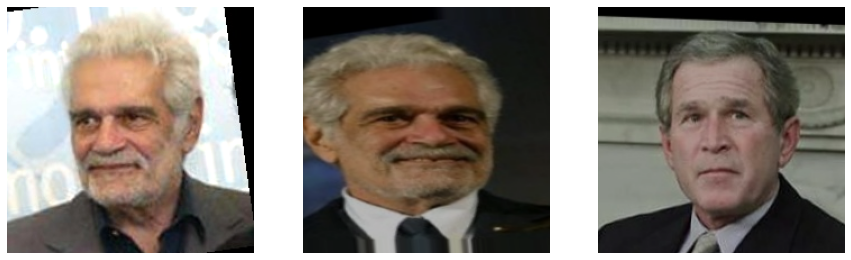

In [180]:
# Plot the original and three augmented samples side by side
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# Generate a batch of 3 images by iterating the augmented data generator 3 times
for i in range(3):

    # Get the next augmented image from the iterator
    image = image_dataset_test_pr[1][i]
 
    # Plot the augmented image
    ax[i].imshow(image)
    ax[i].axis('off')

In [194]:
# Calculate scores for test dataset
distances_trained_test = loaded_model_triplet.predict([image_dataset_test_pr[:, 0, :], image_dataset_test_pr[:, 1, :], image_dataset_test_pr[:, 2, :]])

24/24 [==============================] - 71s 3s/step


In [196]:
# Create data frame with the scores and labels
df_distances_t= pd.DataFrame(distances_trained_test).T
df_distances_t.columns = ['positive', 'negative']

In [199]:
df_distances_t.iloc[1]

positive     6.030739
negative    34.590782
Name: 1, dtype: float32